In [69]:
# Import libraries here.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import os, sys, subprocess
import json
from nltk.corpus import stopwords
from sklearn.feature_extraction import text 

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [70]:
# load project config

terminal_call = ! git rev-parse --show-toplevel
repo_path=terminal_call[0]
project_config_path = os.path.join(repo_path,'project_config.json')

with open(project_config_path,'r') as fp: 
    project_config = json.load(fp)


project_config

{'project_module_relative_path': 'src'}

In [71]:
# import custom scraper module

module_path = os.path.join(repo_path,project_config['project_module_relative_path'])
sys.path.append(module_path)

import scraper
from scraper import words

from importlib import reload

## Read in Data

In [2]:
# read in data
df = pd.read_csv('../data/who_tweets_clean.csv', )

In [43]:
# set column types
df['text'] = df['text'].astype(str)
df['date'] = pd.to_datetime(df['date'])

In [44]:
df.shape

(6191, 2)

## EDA

### Remove Stop Words

In [77]:
# from the eda, remove popular wards that are not that significant
common_words = ["cases", "transmission", "health", "care", "emergency", "people", "million", "billion", "amp", "low", "middle", "income",
               "country", "countries", "risk", "international"]

# remove time stop words
time_words = ["time", "today", "tomorrow", "yesterday", 
             "morning", "afternoon", "night",
             "day", "week", "weekend", "month", "year",
              "days", "weeks", "weekends", "months", "years",
             "monday", "tuesday", "wednesday", "thursday", "friday", "satudray", "sunday",
             "mon", "tues", "wed", "thurs", "fri", "sat", "sun"
             "january", "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december",
             "jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"
            ]


# add the lists together
additional_stop_words = time_words + common_words

### Start with Common Words

In [78]:
# create a count vectorizer for singular words
cvec = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(additional_stop_words),  # add my custom stop words to default 'english'
                       min_df=5, 
                       ngram_range=(1,1),
                       max_df=1.0)

In [79]:
# get the top words in 2019
words_2019 = words.top_words(cvec1, df[df['date'] < '2020-01-01']['text'])

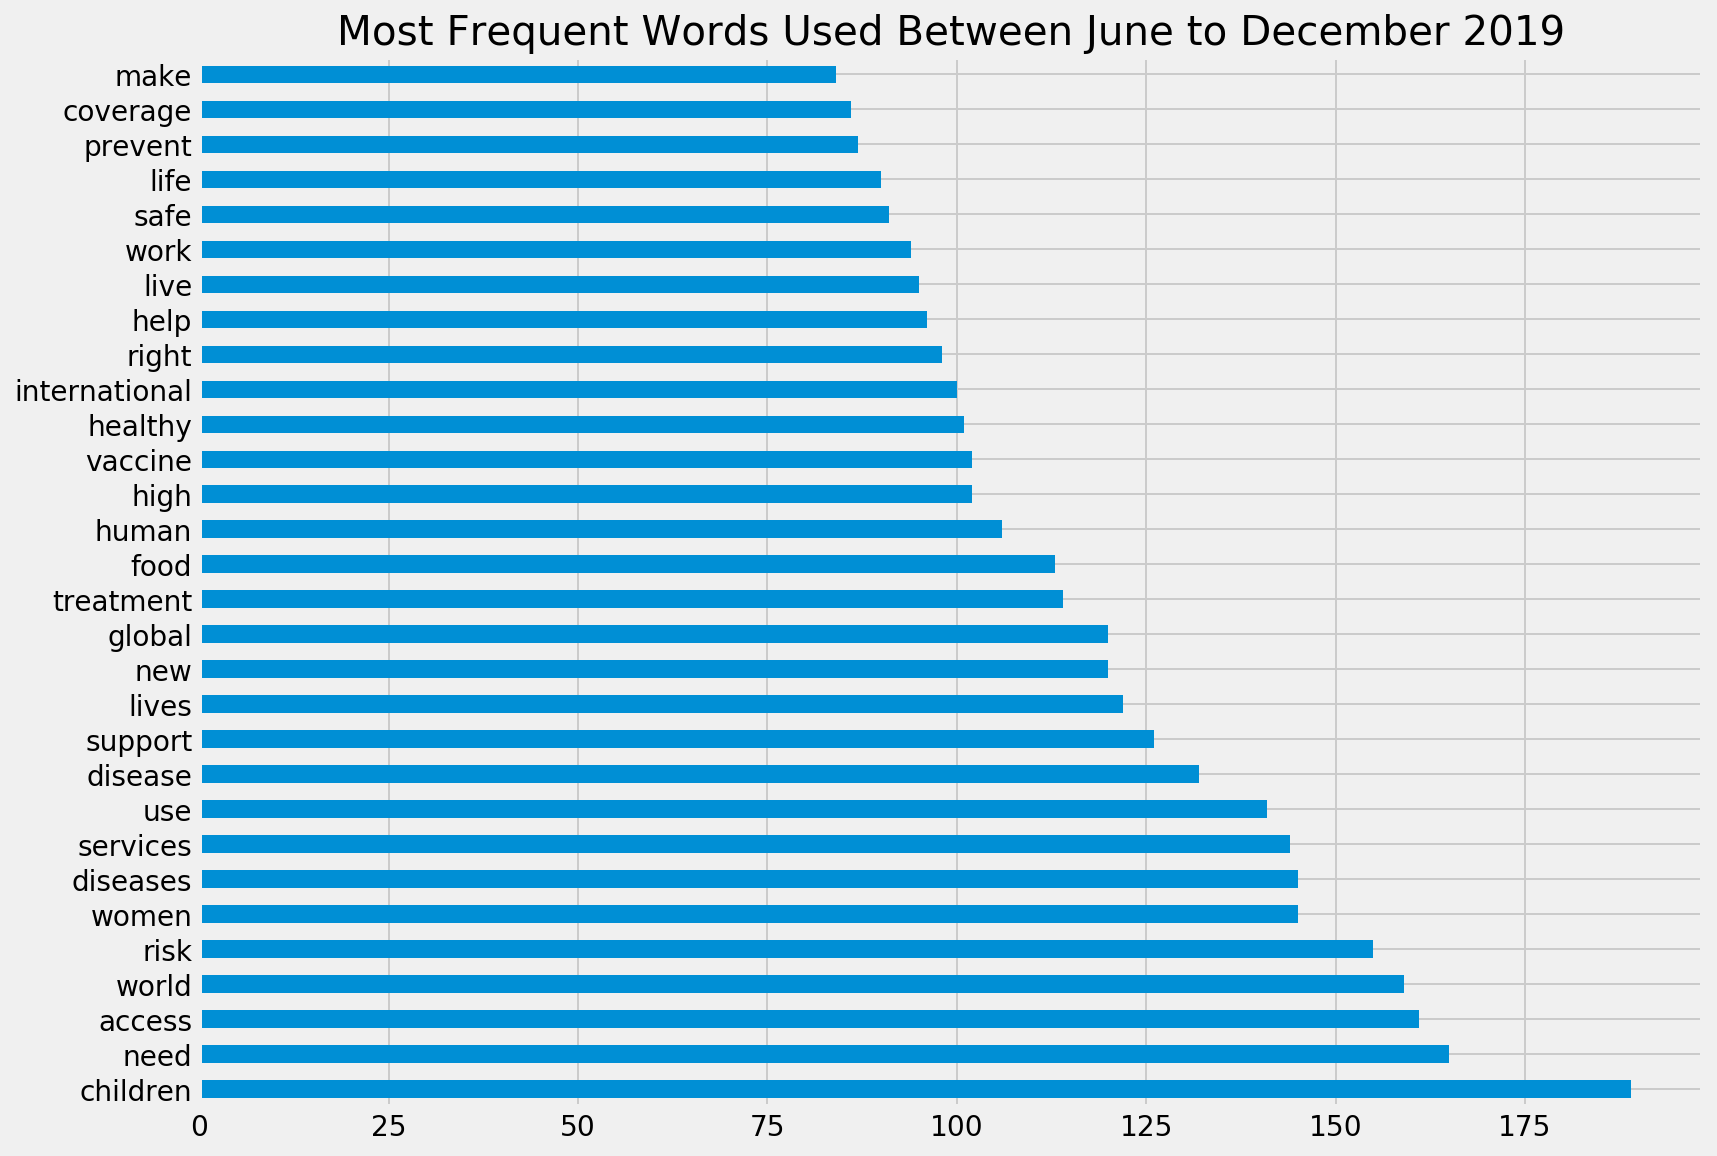

In [82]:
# Visualize the top words between each subreddit
words_2019.plot(y=[0, 1], kind="barh", figsize= (12,9))
plt.title("Most Frequent Words Used Between June to December 2019")
# plt.legend(labels=["Before March 15"])
plt.savefig("../plots/top_words_2019.png");

In [83]:
# get the top words in 2020
words_2020 = words.top_words(cvec1, df[df['date'] > '2020-01-01']['text'])

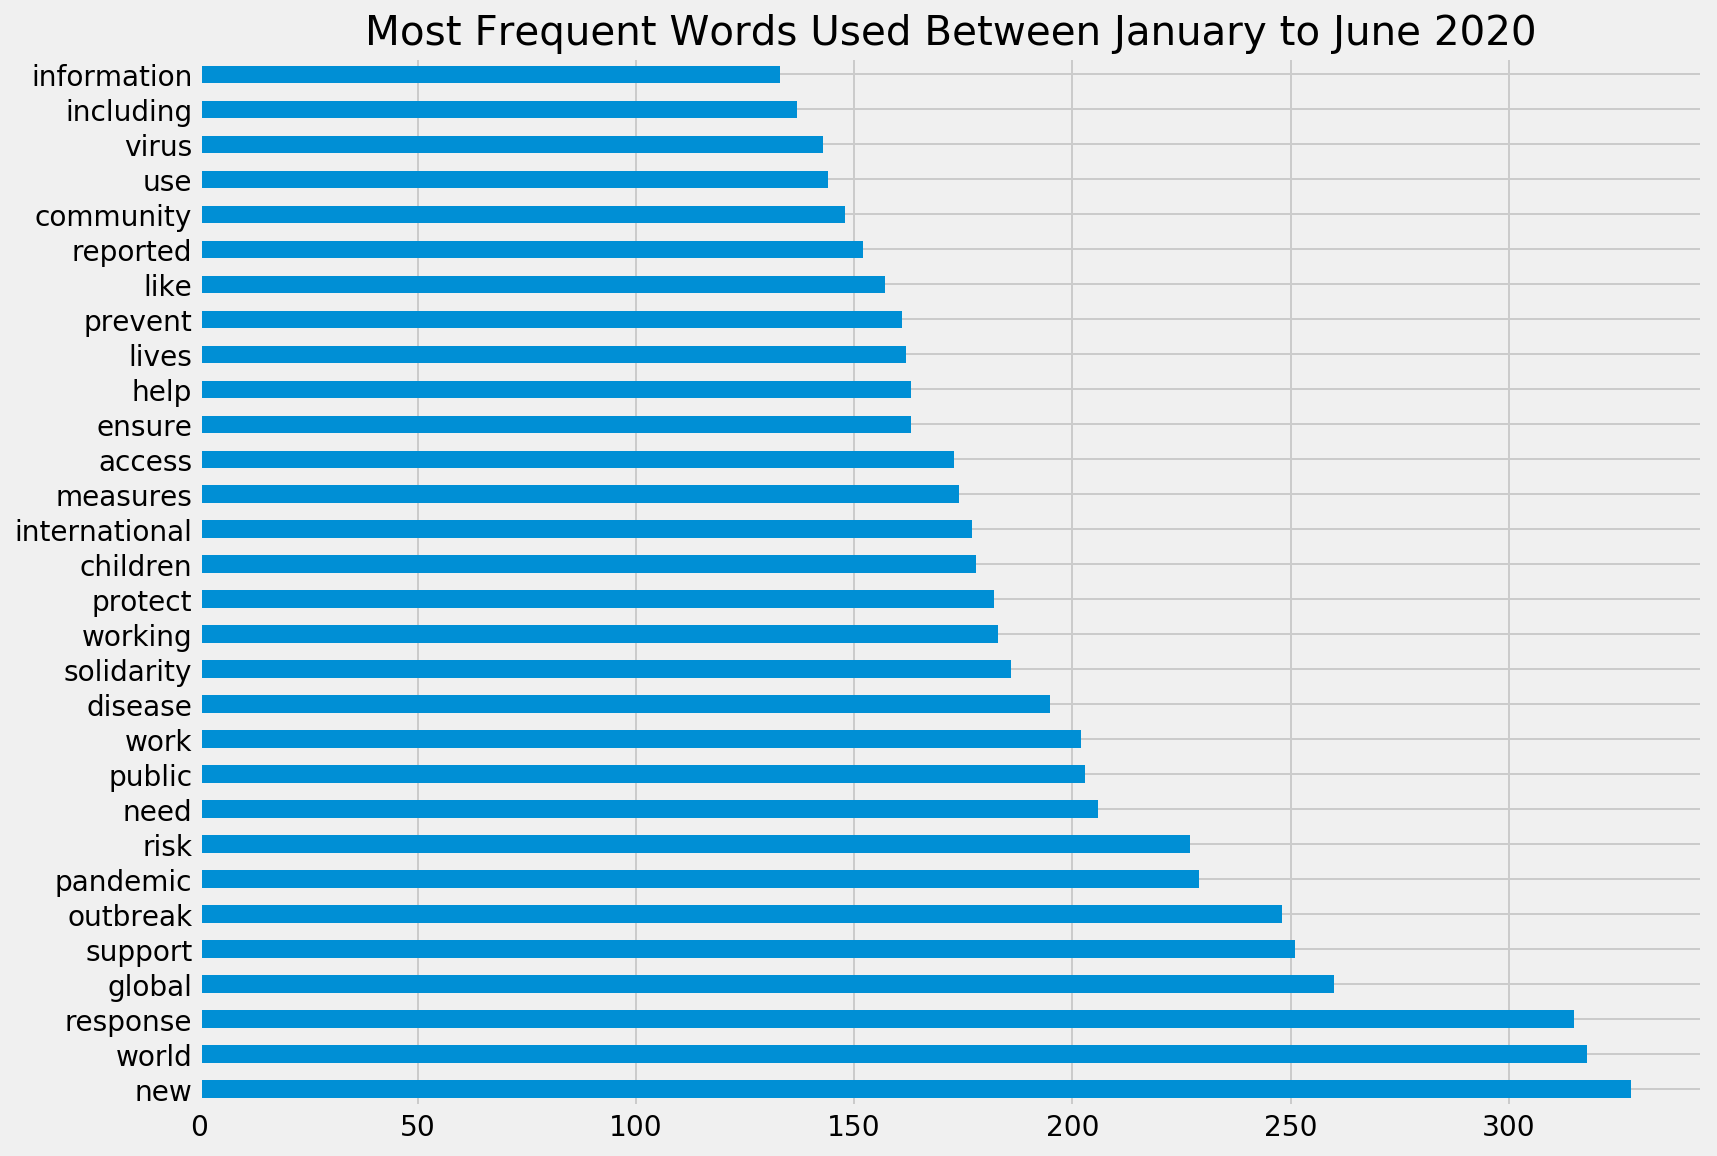

In [85]:
# Visualize the top words between each subreddit
words_2020.plot(y=[0, 1], kind="barh", figsize= (12,9))
plt.title("Most Frequent Words Used Between January to June 2020")
# plt.legend(labels=["Before March 15"])
plt.savefig("../plots/top_words_2020.png");

### Visualize bigrams

In [28]:
# tokenize my words
cvec = CountVectorizer(stop_words=text.ENGLISH_STOP_WORDS.union(additional_stop_words), # adds my custom list of stop words to the default english one 
                       min_df=5, 
                       ngram_range=(2,3), # select for bigrams
                       max_df=1.0)

In [29]:
before_march_15 = df[df['date'] < '2020-03-15']

In [30]:
# fit and transform my data into the countvectorizer
term_mat = cvec.fit_transform(before_march_15['text'])

In [31]:
# create into dataframe
term_df = pd.DataFrame(term_mat.toarray(), columns=cvec.get_feature_names())

In [120]:
# insert my class column into my term dataframe
# term_df.insert(0, 'before_march_15', date)

In [32]:
# sort for the top 30 bigrams
top_bigrams = term_df.mean().T.sort_values(0, ascending=False).head(50)

In [24]:
df[df['text'].str.contains('collaboration')].sort_values('date', ascending = False)

ValueError: cannot index with vector containing NA / NaN values

In [33]:
top_bigrams

universal coverage                     0.018337
save lives                             0.015825
income countries                       0.014820
situation report                       0.014820
physical activity                      0.012308
international regulations              0.011806
new ncov                               0.011304
novel ncov                             0.009797
regulations committee                  0.009545
international regulations committee    0.009545
middle income                          0.009545
low middle                             0.009294
low middle income                      0.009294
human right                            0.009043
middle income countries                0.009043
nurses midwives                        0.008541
prevent spread                         0.007787
protective equipment                   0.007787
make sure                              0.007787
personal protective                    0.007285
noncommunicable diseases               0

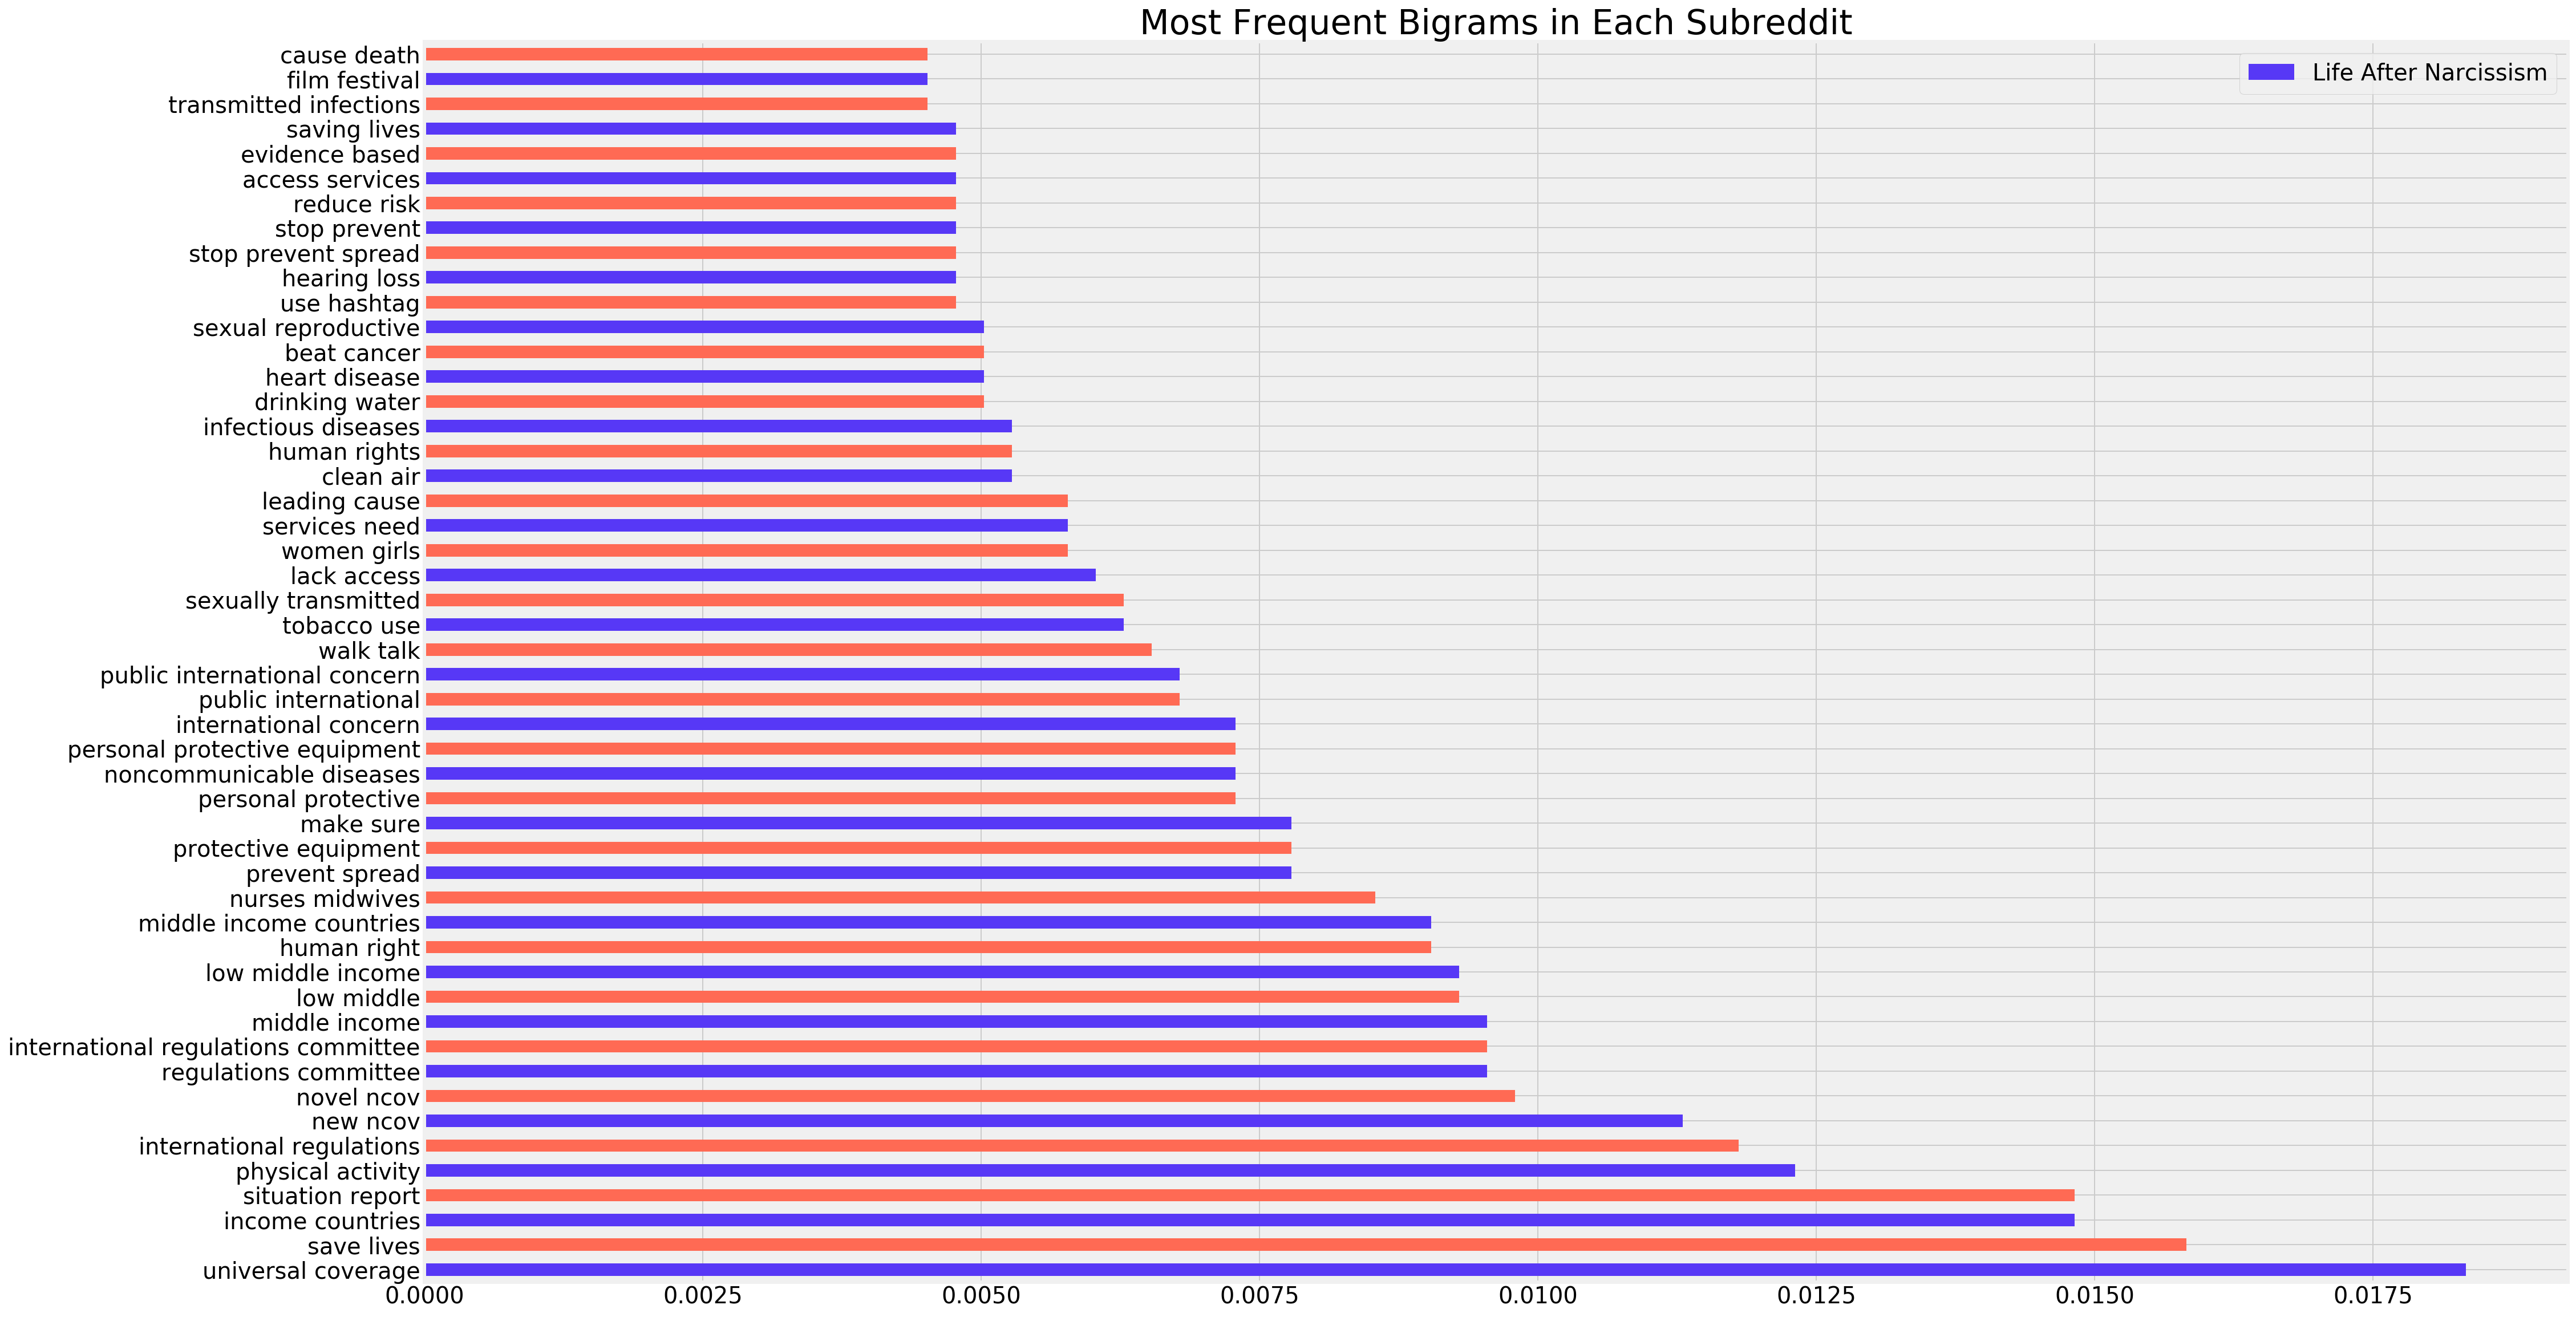

In [34]:
# Visualize the top words between each subreddit
top_bigrams.plot(y=[0, 1], kind="barh", color = ["#5738f6", "#ff6a54"], figsize= (30,20), fontsize=20)
plt.title("Most Frequent Bigrams in Each Subreddit", fontsize=30)
plt.legend(labels=["Life After Narcissism", "Raised By Narcissists"], fontsize =20)
# plt.savefig("../plots/top_bigrams.png");